In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ift6758.training import AdvancedModel
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

In [3]:
train_val = pd.read_pickle('../../notebooks/Milestone2/TrainValSets.pkl')
X_all = train_val.drop(['is_goal'], axis=1)
y_all = train_val['is_goal']

train2_val = pd.read_pickle('../../notebooks/Milestone2/TrainValSets2.pkl')
X2_all = train2_val.drop(['is_goal'], axis=1)
y2_all = train2_val['is_goal']

# Split into train val
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_all, y2_all, test_size=0.3, random_state=42)


In [10]:
modelsDict = {
    'xgboost distance and angle': AdvancedModel(pickle.load(open('../../train/xgboost_distance-angle/model.pkl', 'rb'))).get_pred_proba(X2_val[['distance_goal', 'angle_shot']])
    ,'xgboost allFeatures': AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).get_pred_proba(X2_val[['period' ,'game_seconds' ,'x', 'y', 'empty_net', 'prev_x', 'prev_y', 'time_since_prev', 'distance_from_prev', 'distance_goal', 'prev_distance_goal', 'angle_shot', 'prev_angle_shot', 'bounce', 'angle_change', 'speed', 'shot_type_Deflected', 'shot_type_Slap_Shot' ,'shot_type_Snap_Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around', 'shot_type_Wrist_Shot', 'prev_type_FACEOFF', 'prev_type_GIVEAWAY', 'prev_type_GOAL', 'prev_type_HIT', 'prev_type_MISSED_SHOT', 'prev_type_PENALTY' ,'prev_type_SHOT' ,'prev_type_TAKEAWAY']])
,'xgboost RFECV top 18 Features': AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top18/model.pkl', 'rb'))).get_pred_proba(X2_val[['empty_net','distance_goal','shot_type_Wrap-around','y','shot_type_Slap_Shot','shot_type_Snap_Shot','period','shot_type_Deflected','prev_type_HIT','time_since_prev','angle_shot','shot_type_Tip-In','prev_type_GIVEAWAY','shot_type_Wrist_Shot','game_seconds','angle_change','speed','prev_type_SHOT']])
}

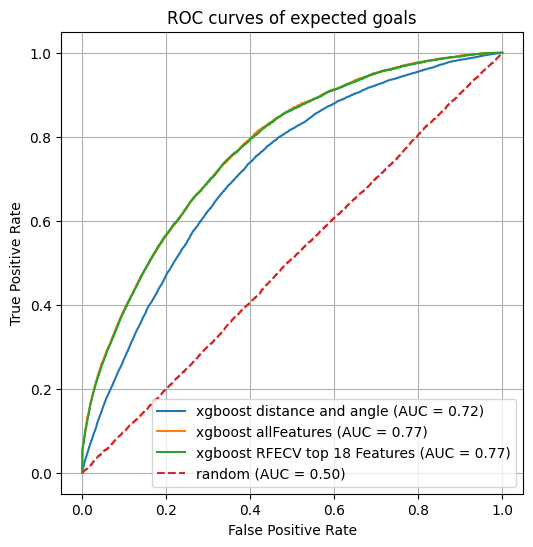

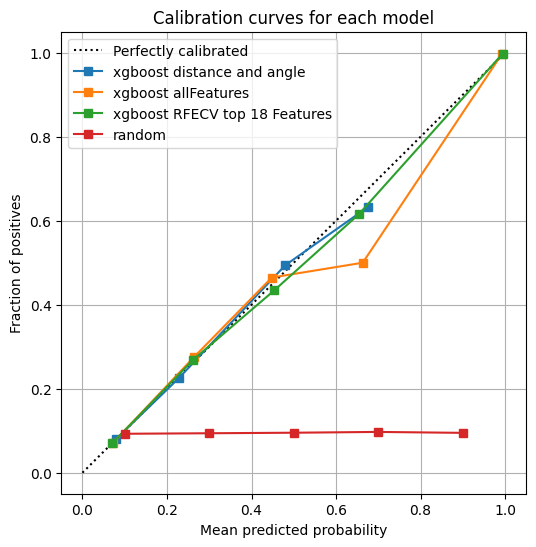

/Users/JJKaufman/DESS/IFT6758/IFT6758-A5-NHL/ift6758/training/plot.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate = df.groupby(centiles).is_goal.mean()


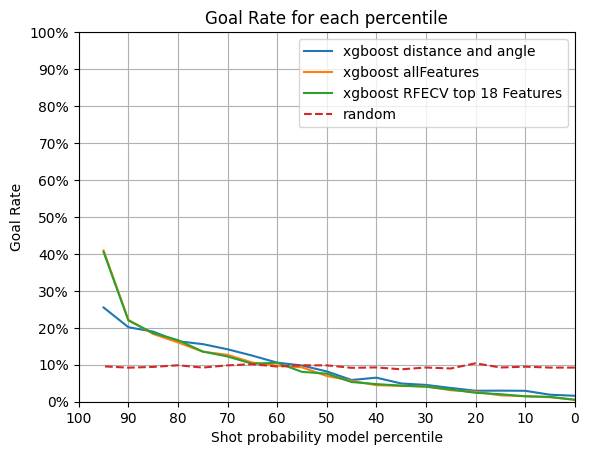

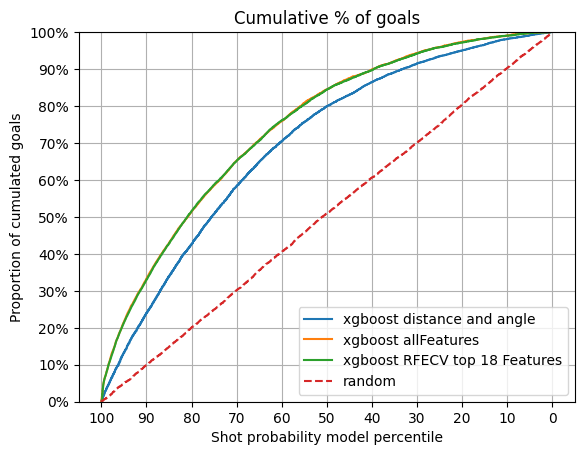

In [11]:
from ift6758.training.plot import plot_all
plot_all(modelsDict, y2_val)

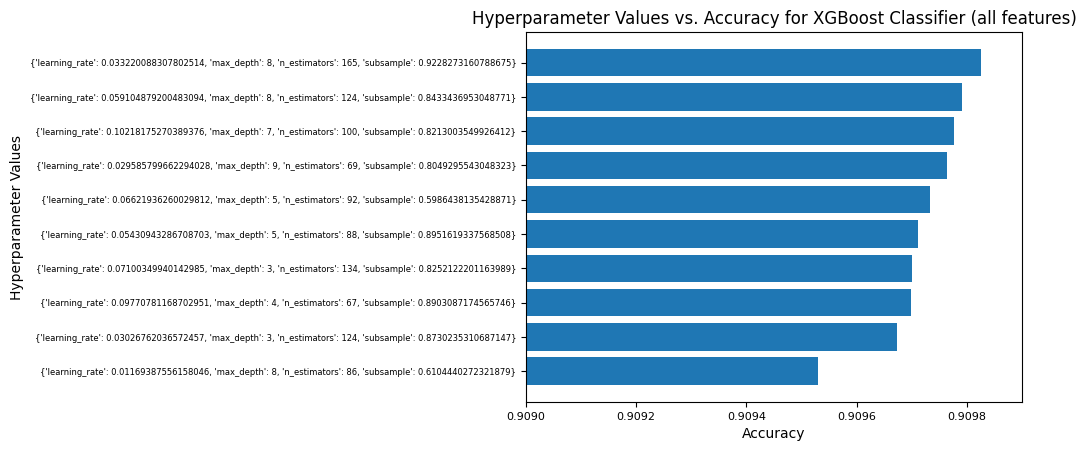

In [15]:
AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).hp_plot()

In [16]:
import matplotlib.pyplot as plt
y1 = AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).clf.feature_importances_
x1 = AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).clf.get_booster().feature_names

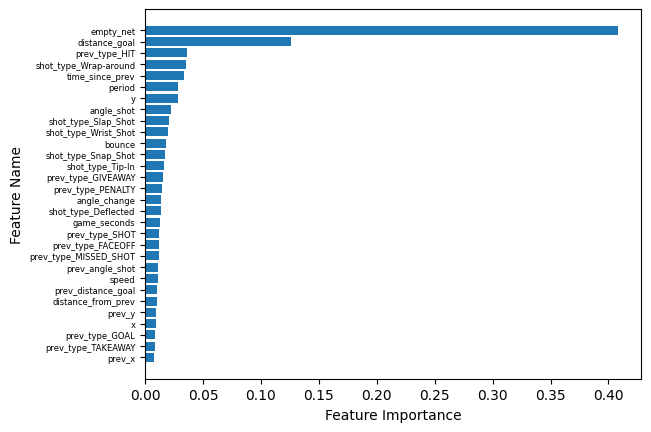

In [17]:
res = [list(i) for i in zip(*sorted(zip(y1, x1),
                                  key = lambda dual: dual[0]))]
x2 = res[1]
y2 = res[0]
plt.barh(x2, y2)
plt.yticks(range(len(x2)), x2, fontsize = 6)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

In [18]:
import numpy as np
np.mean(y2)

0.03333334

In [19]:
np.median(y2)

0.014198288

In [20]:
np.sum(y2>(np.mean(y2)-(.2)*np.std(y2)))

10

In [21]:
import xgboost as xgb
modele = AdvancedModel(xgb.XGBClassifier())

In [22]:
newX_train = modele.featureSelect(X2_train, y2_train)

In [23]:
newX_train

,empty_net
66240,False
192026,False
96963,False
63577,False
156159,False
...,...
119879,False
259178,False
131932,False
146867,False


In [24]:
scores = modele.featScores['mean_test_score']

In [25]:
names = modele.rfecv.feature_names_in_

In [26]:
ranking = modele.rfecv.ranking_

In [27]:
feats = [list(i) for i in zip(*sorted(zip(names, ranking),
                                  key = lambda dual: dual[1]))]

In [28]:
feats[0][0:7]

['empty_net',
 'distance_goal',
 'shot_type_Wrap-around',
 'y',
 'shot_type_Slap_Shot',
 'shot_type_Snap_Shot',
 'period']

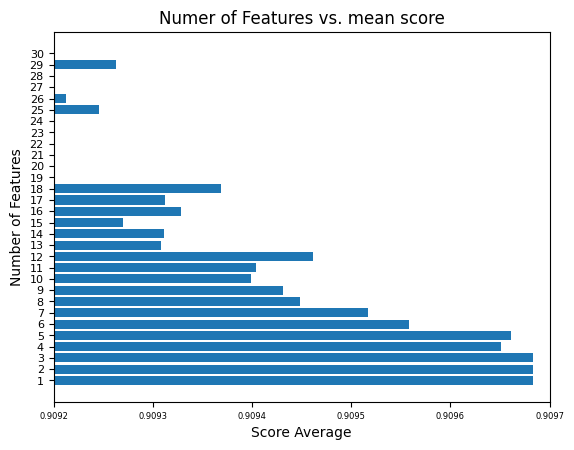

In [29]:
plt.barh(range(1, len(scores)+1), scores)        
plt.xlim(0.9092, .9097)
plt.yticks(range(1, len(scores)+1), range(1, len(scores)+1), fontsize = 8)
plt.xticks(fontsize = 6)
plt.xlabel('Score Average')
plt.ylabel('Number of Features')
plt.title('Numer of Features vs. mean score')
plt.show()

In [30]:
modele.selectedFeatures

array([4])

In [31]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Create the LASSO model
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

lasso_model = LassoCV(cv = kfold)

# Fit the model
lasso_model.fit(X2_train, y2_train)

# Get selected features
selected_features = X2_train.columns[lasso_model.coef_ != 0]

In [32]:
selected_features

Index(['game_seconds', 'x', 'prev_y', 'time_since_prev', 'distance_from_prev',
       'distance_goal', 'prev_distance_goal', 'angle_shot', 'prev_angle_shot',
       'speed'],
      dtype='object')

In [33]:
lasso_model.coef_

array([-0.00000000e+00,  1.66483608e-05, -7.51816540e-06, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.39076347e-05, -2.37106208e-04,
       -5.43573930e-04, -1.68833615e-03,  3.41911818e-04,  4.62824932e-05,
        1.95254343e-05,  0.00000000e+00, -0.00000000e+00,  1.41352815e-03,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

Text(0.5, 1.0, 'LASSO: Features vs. Coefficient Values')

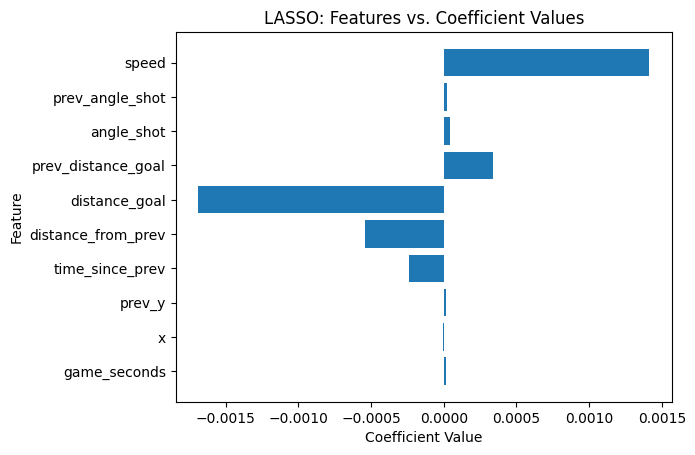

In [34]:
plt.barh(selected_features, lasso_model.coef_[lasso_model.coef_ != 0])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('LASSO: Features vs. Coefficient Values')

In [35]:
import shap


In [36]:
mo = AdvancedModel(xgb.XGBClassifier())

In [37]:
mo.train(X2_train, y2_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
explainer = shap.Explainer(mo.clf)
shap_values = explainer(X2_train)

[14:27:00] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
shap.plots.bar(shap_values, max_display = 30)

In [52]:
lasso = AdvancedModel(pickle.load(open('../../train/xgboost_LASSO/model.pkl', 'rb')))

In [57]:
lassoSEL = ['game_seconds', 'x', 'prev_y', 'time_since_prev', 'distance_from_prev',
       'distance_goal', 'prev_distance_goal', 'angle_shot','speed','prev_angle_shot']

In [58]:
y2_pred, accuracyLasso = lasso.evaluate(X2_val[lassoSEL], y2_val)

In [60]:
accuracyLasso

0.9059312936124531

In [131]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
cm_Lasso = confusion_matrix(y2_val, y2_pred)
precision_Lasso = precision_score(y2_val, y2_pred)
recall_Lasso = recall_score(y2_val, y2_pred)
f1_Lasso = f1_score(y2_val, y2_pred)

In [61]:
lasso2Sel = ['game_seconds', 'prev_y', 'time_since_prev', 'distance_from_prev',
       'distance_goal', 'prev_distance_goal', 'angle_shot','speed','prev_angle_shot']

In [62]:
lasso2 = AdvancedModel(pickle.load(open('../../train/xgboost_LASSO2/model.pkl', 'rb')))

In [63]:
y2_pred2, accuracyLasso2 = lasso2.evaluate(X2_val[lasso2Sel], y2_val)

In [64]:
accuracyLasso2

0.9059536589729826

In [132]:
cm_Lasso2 = confusion_matrix(y2_val, y2_pred2)
precision_Lasso2= precision_score(y2_val, y2_pred2)
recall_Lasso2 = recall_score(y2_val, y2_pred2)
f1_Lasso2 = f1_score(y2_val, y2_pred2)

In [68]:
shap01Sel = ['distance_goal', 'y' ,'time_since_prev', 'shot_type_Slap_Shot','angle_shot','game_seconds','speed','empty_net', 'prev_distance_goal' , 'shot_type_Snap_Shot' ,'distance_from_prev', 'x', 'shot_type_Wrist_Shot']


In [66]:
shap1 = AdvancedModel(pickle.load(open('../../train/xgboost_SHAP01/model.pkl', 'rb')))

In [69]:
y2_pred3, accuracySHAP1 = shap1.evaluate(X2_val[shap01Sel], y2_val)

In [70]:
accuracySHAP1

0.909565664698515

In [135]:
cm_SHAP1 = confusion_matrix(y2_val, y2_pred3)
precision_SHAP1= precision_score(y2_val, y2_pred3)
recall_SHAP1 = recall_score(y2_val, y2_pred3)
f1_SHAP1 = f1_score(y2_val, y2_pred3)

In [71]:
shap02Sel = ['distance_goal', 'y' ,'time_since_prev', 'shot_type_Slap_Shot','angle_shot','game_seconds','speed','empty_net', 'prev_distance_goal' , 'shot_type_Snap_Shot']


In [72]:
shap2 = AdvancedModel(pickle.load(open('../../train/xgboost_SHAP02/model.pkl', 'rb')))


In [73]:
y2_pred4, accuracySHAP2 = shap2.evaluate(X2_val[shap02Sel], y2_val)

In [74]:
accuracySHAP2

0.9096103954195741

In [136]:
cm_SHAP2 = confusion_matrix(y2_val, y2_pred4)
precision_SHAP2= precision_score(y2_val, y2_pred4)
recall_SHAP2 = recall_score(y2_val, y2_pred4)
f1_SHAP2 = f1_score(y2_val, y2_pred4)

In [80]:
shap03Sel = ['distance_goal', 'y' ,'time_since_prev', 'shot_type_Slap_Shot','angle_shot','game_seconds','speed','empty_net', 'prev_distance_goal' , 'shot_type_Snap_Shot' ,'distance_from_prev', 'x', 'shot_type_Wrist_Shot', 'prev_angle_shot','shot_type_Tip-In','prev_y','angle_change','prev_x','prev_type_HIT']


In [81]:
shap3 = AdvancedModel(pickle.load(open('../../train/xgboost_SHAP03/model.pkl', 'rb')))


In [82]:
y2_pred5, accuracySHAP3 = shap3.evaluate(X2_val[shap03Sel], y2_val)

In [83]:
accuracySHAP3

0.909621578099839

In [137]:
cm_SHAP3 = confusion_matrix(y2_val, y2_pred5)
precision_SHAP3= precision_score(y2_val, y2_pred5)
recall_SHAP3 = recall_score(y2_val, y2_pred5)
f1_SHAP3 = f1_score(y2_val, y2_pred5)

In [84]:
top05Sel = ['empty_net', 'distance_goal', 'prev_type_HIT', 'shot_type_Wrap-around', 'time_since_prev']

In [86]:
top5 = AdvancedModel(pickle.load(open('../../train/xgboost_top5/model.pkl', 'rb')))


In [87]:
y2_pred6, accuracytop5 = top5.evaluate(X2_val[top05Sel], y2_val)

In [88]:
accuracytop5

0.9095992127393093

In [138]:
cm_top5 = confusion_matrix(y2_val, y2_pred6)
precision_top5= precision_score(y2_val, y2_pred6)
recall_top5 = recall_score(y2_val, y2_pred6)
f1_top5 = f1_score(y2_val, y2_pred6)

In [89]:
top10Sel = ['empty_net', 'distance_goal', 'prev_type_HIT', 'shot_type_Wrap-around', 'time_since_prev','period', 'y', 'angle_shot' ,'shot_type_Slap_Shot', 'shot_type_Wrist_Shot']


In [90]:
top10 = AdvancedModel(pickle.load(open('../../train/xgboost_top10/model.pkl', 'rb')))


In [91]:
y2_pred7, accuracytop10 = top10.evaluate(X2_val[top10Sel], y2_val)

In [92]:
accuracytop10

0.9095880300590445

In [139]:
cm_top10 = confusion_matrix(y2_val, y2_pred7)
precision_top10= precision_score(y2_val, y2_pred7)
recall_top10 = recall_score(y2_val, y2_pred7)
f1_top10 = f1_score(y2_val, y2_pred7)

In [93]:
top07Sel = ['empty_net', 'distance_goal', 'prev_type_HIT', 'shot_type_Wrap-around', 'time_since_prev','period', 'y']


In [94]:
top7 = AdvancedModel(pickle.load(open('../../train/xgboost_top7/model.pkl', 'rb')))


In [95]:
y2_pred8, accuracytop7 = top7.evaluate(X2_val[top07Sel], y2_val)

In [96]:
accuracytop7

0.9096103954195741

In [140]:
cm_top7 = confusion_matrix(y2_val, y2_pred8)
precision_top7= precision_score(y2_val, y2_pred8)
recall_top7 = recall_score(y2_val, y2_pred8)
f1_top7 = f1_score(y2_val, y2_pred8)

In [97]:
#trying one top 5 RFECV selected

In [98]:
feats[0][0:18]

['empty_net',
 'distance_goal',
 'shot_type_Wrap-around',
 'y',
 'shot_type_Slap_Shot',
 'shot_type_Snap_Shot',
 'period',
 'shot_type_Deflected',
 'prev_type_HIT',
 'time_since_prev',
 'angle_shot',
 'shot_type_Tip-In',
 'prev_type_GIVEAWAY',
 'shot_type_Wrist_Shot',
 'game_seconds',
 'angle_change',
 'speed',
 'prev_type_SHOT']

In [99]:
top18RFECV = feats[0][0:18]

In [165]:
top18RFECV

['empty_net',
 'distance_goal',
 'shot_type_Wrap-around',
 'y',
 'shot_type_Slap_Shot',
 'shot_type_Snap_Shot',
 'period',
 'shot_type_Deflected',
 'prev_type_HIT',
 'time_since_prev',
 'angle_shot',
 'shot_type_Tip-In',
 'prev_type_GIVEAWAY',
 'shot_type_Wrist_Shot',
 'game_seconds',
 'angle_change',
 'speed',
 'prev_type_SHOT']

In [100]:
RFECVtop18 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top18/model.pkl', 'rb')))

In [101]:
y2_pred9, accuracyRFECVtop18 = RFECVtop18.evaluate(X2_val[top18RFECV], y2_val)

In [102]:
accuracyRFECVtop18

0.9097110395419574

In [141]:
cm_RFECVtop18 = confusion_matrix(y2_val, y2_pred9)
precision_RFECVtop18= precision_score(y2_val, y2_pred9)
recall_RFECVtop18 = recall_score(y2_val, y2_pred9)
f1_RFECVtop18 = f1_score(y2_val, y2_pred9)

In [103]:
top12RFECV= feats[0][0:12]

In [104]:
RFECVtop12 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top12/model.pkl', 'rb')))

In [105]:
y2_pred10, accuracyRFECVtop12 = RFECVtop12.evaluate(X2_val[top12RFECV], y2_val)

In [106]:
accuracyRFECVtop12

0.9095432993379853

In [142]:
cm_RFECVtop12 = confusion_matrix(y2_val, y2_pred10)
precision_RFECVtop12= precision_score(y2_val, y2_pred10)
recall_RFECVtop12 = recall_score(y2_val, y2_pred10)
f1_RFECVtop12 = f1_score(y2_val, y2_pred10)

In [107]:
top7RFECV = feats[0][0:7]

In [108]:
RFECVtop7 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top7/model.pkl', 'rb')))

In [109]:
y2_pred11, accuracyRFECVtop7 = RFECVtop7.evaluate(X2_val[top7RFECV], y2_val)

In [110]:
accuracyRFECVtop7

0.9095992127393093

In [143]:
cm_RFECVtop7 = confusion_matrix(y2_val, y2_pred11)
precision_RFECVtop7= precision_score(y2_val, y2_pred11)
recall_RFECVtop7 = recall_score(y2_val, y2_pred11)
f1_RFECVtop7 = f1_score(y2_val, y2_pred11)

In [111]:
top5RFECV = feats[0][0:5]

In [112]:
RFECVtop5 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top5/model.pkl', 'rb')))

In [113]:
y2_pred12, accuracyRFECVtop5 = RFECVtop5.evaluate(X2_val[top5RFECV], y2_val)

In [114]:
accuracyRFECVtop5

0.9095992127393093

In [144]:
cm_RFECVtop5 = confusion_matrix(y2_val, y2_pred12)
precision_RFECVtop5= precision_score(y2_val, y2_pred12)
recall_RFECVtop5 = recall_score(y2_val, y2_pred12)
f1_RFECVtop5 = f1_score(y2_val, y2_pred12)

In [115]:
dict = {'RFECV Top 5':accuracyRFECVtop5,'RFECV Top 7':accuracyRFECVtop7,'RFECV Top 12': accuracyRFECVtop12,'RFECV Top 18':accuracyRFECVtop18,'LASSO': accuracyLasso, 'LASSO 2 Removed x':accuracyLasso2, 'SHAP > .05':accuracySHAP1,'SHAP > .07':accuracySHAP2,'SHAP>.03':accuracySHAP3, 'Top 10': accuracytop10, 'Top 5': accuracytop5, 'Top 7': accuracytop7}


In [145]:
prec_dict = {'RFECV Top 5':precision_RFECVtop5,'RFECV Top 7':precision_RFECVtop7,'RFECV Top 12': precision_RFECVtop12,'RFECV Top 18':precision_RFECVtop18,'LASSO': precision_Lasso, 'LASSO 2 Removed x':precision_Lasso2, 'SHAP > .05':precision_SHAP1,'SHAP > .07':precision_SHAP2,'SHAP>.03':precision_SHAP3, 'Top 10': precision_top10, 'Top 5': precision_top5, 'Top 7': precision_top7}


In [146]:
recall_dict = {'RFECV Top 5':recall_RFECVtop5,'RFECV Top 7':recall_RFECVtop7,'RFECV Top 12': recall_RFECVtop12,'RFECV Top 18':recall_RFECVtop18,'LASSO': recall_Lasso, 'LASSO 2 Removed x':recall_Lasso2, 'SHAP > .05':recall_SHAP1,'SHAP > .07':recall_SHAP2,'SHAP>.03':recall_SHAP3, 'Top 10': recall_top10, 'Top 5': recall_top5, 'Top 7': recall_top7}
f1_dict = {'RFECV Top 5':f1_RFECVtop5,'RFECV Top 7':f1_RFECVtop7,'RFECV Top 12': f1_RFECVtop12,'RFECV Top 18':f1_RFECVtop18,'LASSO': f1_Lasso, 'LASSO 2 Removed x':f1_Lasso2, 'SHAP > .05':f1_SHAP1,'SHAP > .07':f1_SHAP2,'SHAP>.03':f1_SHAP3, 'Top 10': f1_top10, 'Top 5': f1_top5, 'Top 7': f1_top7}


Text(0.5, 1.0, 'Feature Selection Method vs. Accuracy on Validation Set')

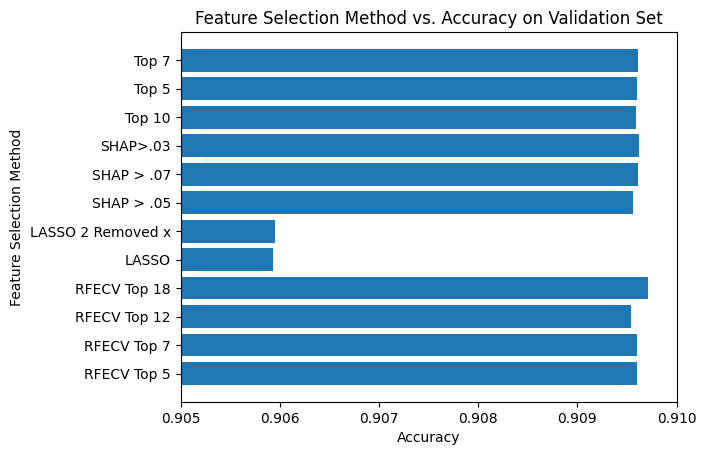

In [120]:
plt.barh(*zip(*dict.items()))
plt.xlim(.905, .91)
plt.xlabel('Accuracy')
plt.ylabel('Feature Selection Method')
plt.title('Feature Selection Method vs. Accuracy on Validation Set')

Text(0.5, 1.0, 'Feature Selection Method vs. Accuracy on Validation Set')

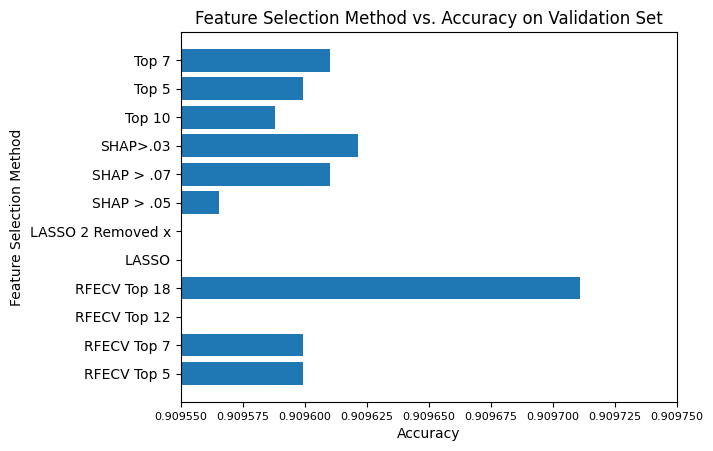

In [128]:
plt.barh(*zip(*dict.items()))
plt.xlim(.90955, .90975)
plt.xlabel('Accuracy')
plt.ylabel('Feature Selection Method')
plt.xticks(fontsize=8)
plt.title('Feature Selection Method vs. Accuracy on Validation Set')

Text(0.5, 1.0, 'Feature Selection Method vs. Precision on Validation Set')

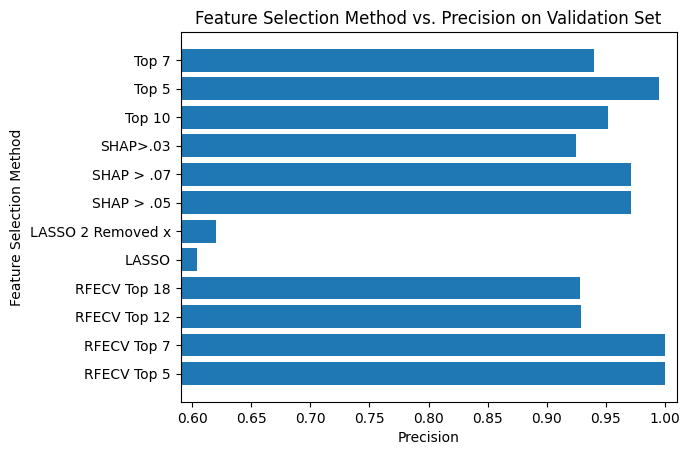

In [151]:
plt.barh(*zip(*prec_dict.items()))
plt.xlim(.59, 1.01)
plt.xlabel('Precision')
plt.ylabel('Feature Selection Method')
plt.title('Feature Selection Method vs. Precision on Validation Set')

Text(0.5, 1.0, 'Feature Selection Method vs. Recall on Validation Set')

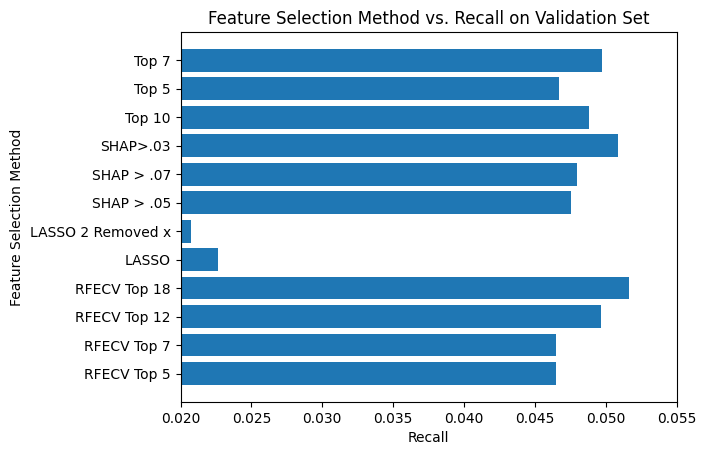

In [158]:
plt.barh(*zip(*recall_dict.items()))
plt.xlim(0.02, .055)
plt.xlabel('Recall')
plt.ylabel('Feature Selection Method')
plt.title('Feature Selection Method vs. Recall on Validation Set')

Text(0.5, 1.0, 'Feature Selection Method vs. F1 Scores on Validation Set')

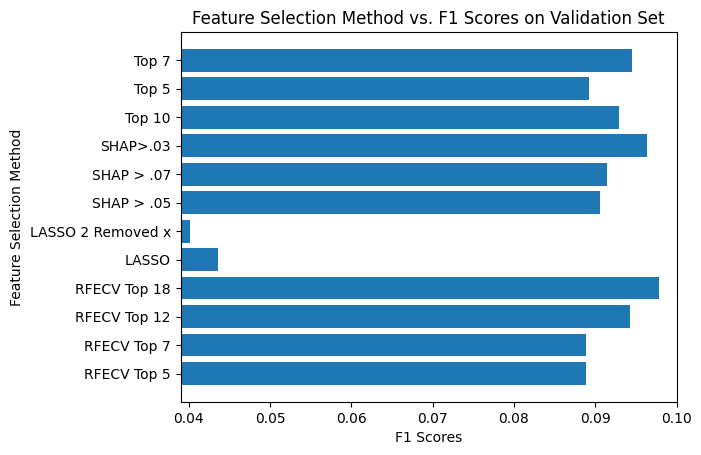

In [164]:
plt.barh(*zip(*f1_dict.items()))
plt.xlim(0.039, .1)
plt.xlabel('F1 Scores')
plt.ylabel('Feature Selection Method')
plt.title('Feature Selection Method vs. F1 Scores on Validation Set')

In [ ]:
#RECALL DEEMED MOST IMPORTANT METRIC DUE TO THE FACT THAT WE WANT TO MINIMIZE FALSE NEGATIVES (i.e. predicting a miss when its a goal)
#due to the high prescence of misses in the dataset (way more misses than goals)
#RFECV top 18 features had the highest Recall metric, as well as the highest accuracy but that couldn't
#be considered alone due to the class imbalance in the training set
